
# MNIST Feed-Forward Neural Network Experiments (Keras)


In [ ]:
!pip -q install -U tensorflow matplotlib numpy pandas

#  1) Setup & Data Loading 

In [1]:
import time, math, json, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

print("TensorFlow:", tf.__version__)

# Load MNIST 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# One-hot labels for categorical cross-entropy
num_classes = 10
y_train_oh = to_categorical(y_train, num_classes)
y_test_oh  = to_categorical(y_test, num_classes)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


TensorFlow: 2.20.0
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# 2) Model builder

In [2]:
def build_ffnn(hidden_activation="relu", optimizer="adam", hidden_layers=1, units=128, dropout=0.0,
               output_activation="softmax", loss="categorical_crossentropy", from_logits=False):
   
    model = Sequential([Flatten(input_shape=(28, 28))])
    for _ in range(hidden_layers):
        model.add(Dense(units, activation=hidden_activation))
        if dropout > 0:
            model.add(Dropout(dropout))
    model.add(Dense(10, activation=output_activation))

    if loss == "categorical_crossentropy" and from_logits:
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    return model


# 3) Simple timing callback 

In [3]:
class EpochTimer(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self._start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self._start)

def train_and_evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test,
                       epochs=5, batch_size=128, verbose=0):
    timer = EpochTimer()
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[timer],
        verbose=verbose
    )
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    train_time = float(np.sum(timer.epoch_times))
    return history.history, test_acc, test_loss, train_time


# 4) Train/Val split

In [4]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_oh, test_size=0.1, random_state=42, stratify=y_train)
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape


((54000, 28, 28), (6000, 28, 28), (54000, 10), (6000, 10))

# 5) Experiments: hidden activations × optimizers 

In [5]:
activations = ["relu", "sigmoid", "tanh"]
optimizers  = ["adam", "sgd", "rmsprop"]
layers_list = [1]  

EPOCHS = 5
BATCH  = 128

results = []  

for act in activations:
    for opt in optimizers:
        for L in layers_list:
            print(f"Training: act={act}, opt={opt}, layers={L}")
            model = build_ffnn(hidden_activation=act, optimizer=opt, hidden_layers=L, units=128,
                               output_activation="softmax", loss="categorical_crossentropy")
            hist, test_acc, test_loss, train_time = train_and_evaluate(
                model, x_tr, y_tr, x_val, y_val, x_test, y_test_oh,
                epochs=EPOCHS, batch_size=BATCH, verbose=0
            )
            results.append({
                "activation": act,
                "optimizer": opt,
                "layers": L,
                "epochs": EPOCHS,
                "train_time_sec": train_time,
                "test_accuracy": test_acc,
                "test_loss": test_loss,
                "history": hist,
            })

df_results = pd.DataFrame([{k: v for k, v in r.items() if k != "history"} for r in results])
df_results.sort_values(["test_accuracy","train_time_sec"], ascending=[False, True], inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results


Training: act=relu, opt=adam, layers=1


C:\Users\DuaaHilal\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training: act=relu, opt=sgd, layers=1
Training: act=relu, opt=rmsprop, layers=1
Training: act=sigmoid, opt=adam, layers=1
Training: act=sigmoid, opt=sgd, layers=1
Training: act=sigmoid, opt=rmsprop, layers=1
Training: act=tanh, opt=adam, layers=1
Training: act=tanh, opt=sgd, layers=1
Training: act=tanh, opt=rmsprop, layers=1


,activation,optimizer,layers,epochs,train_time_sec,test_accuracy,test_loss
0,relu,adam,1,5,31.440213,0.9721,0.091934
1,relu,rmsprop,1,5,35.935356,0.9709,0.095008
2,tanh,rmsprop,1,5,34.309650,0.9688,0.103869
3,tanh,adam,1,5,1070.658197,0.9665,0.111828
4,sigmoid,rmsprop,1,5,32.670814,0.9521,0.161419
5,sigmoid,adam,1,5,33.950777,0.9511,0.162897
6,tanh,sgd,1,5,25.971551,0.9033,0.360704
7,relu,sgd,1,5,28.178547,0.9031,0.345974
8,sigmoid,sgd,1,5,27.100103,0.8361,0.810344


# 6) Depth comparison

In [6]:
depth_results = []
for L in [1, 2, 4]:
    print(f"Depth run with L={L}")
    model = build_ffnn(hidden_activation="relu", optimizer="adam", hidden_layers=L, units=128,
                       output_activation="softmax", loss="categorical_crossentropy")
    hist, test_acc, test_loss, train_time = train_and_evaluate(
        model, x_tr, y_tr, x_val, y_val, x_test, y_test_oh,
        epochs=EPOCHS, batch_size=BATCH, verbose=0
    )
    depth_results.append({
        "activation": "relu",
        "optimizer": "adam",
        "layers": L,
        "epochs": EPOCHS,
        "train_time_sec": train_time,
        "test_accuracy": test_acc,
        "test_loss": test_loss,
        "history": hist,
    })

df_depth = pd.DataFrame([{k: v for k, v in r.items() if k != "history"} for r in depth_results])
df_depth.sort_values(["layers"], inplace=True)
df_depth.reset_index(drop=True, inplace=True)
df_depth


Depth run with L=1


C:\Users\DuaaHilal\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Depth run with L=2
Depth run with L=4


,activation,optimizer,layers,epochs,train_time_sec,test_accuracy,test_loss
0,relu,adam,1,5,39.241918,0.9707,0.097131
1,relu,adam,2,5,49.988708,0.9724,0.092951
2,relu,adam,4,5,49.293586,0.9724,0.086040


#  7) Does softmax at the output matter?

In [7]:

# (A) Standard: softmax + categorical_crossentropy (probabilities that sum to 1)
model_softmax = build_ffnn(hidden_activation="relu", optimizer="adam", hidden_layers=1, units=128,
                           output_activation="softmax", loss="categorical_crossentropy")
hist_sm, acc_sm, loss_sm, time_sm = train_and_evaluate(
    model_softmax, x_tr, y_tr, x_val, y_val, x_test, y_test_oh,
    epochs=EPOCHS, batch_size=BATCH, verbose=0
)


C:\Users\DuaaHilal\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# (B) Linear logits + CategoricalCrossentropy(from_logits=True)
model_logits = build_ffnn(hidden_activation="relu", optimizer="adam", hidden_layers=1, units=128,
                          output_activation="linear", loss="categorical_crossentropy", from_logits=True)
hist_log, acc_log, loss_log, time_log = train_and_evaluate(
    model_logits, x_tr, y_tr, x_val, y_val, x_test, y_test_oh,
    epochs=EPOCHS, batch_size=BATCH, verbose=0
)

C:\Users\DuaaHilal\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# (C) (Not recommended) Sigmoid outputs with binary cross-entropy for multi-class (treating as multi-label)
model_sigout = build_ffnn(hidden_activation="relu", optimizer="adam", hidden_layers=1, units=128,
                          output_activation="sigmoid", loss="binary_crossentropy")
hist_so, acc_so, loss_so, time_so = train_and_evaluate(
    model_sigout, x_tr, y_tr, x_val, y_val, x_test, y_test_oh,
    epochs=EPOCHS, batch_size=BATCH, verbose=0
)

pd.DataFrame({
    "variant": ["softmax+CCE", "linear+CCE(from_logits)", "sigmoid+BCE"],
    "test_acc": [acc_sm, acc_log, acc_so],
    "test_loss": [loss_sm, loss_log, loss_so],
    "train_time_sec": [time_sm, time_log, time_so],
})


C:\Users\DuaaHilal\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,variant,test_acc,test_loss,train_time_sec
0,softmax+CCE,0.9724,0.090879,40.959901
1,linear+CCE(from_logits),0.9706,0.095511,50.037913
2,sigmoid+BCE,0.9684,0.023366,42.064223


# 8) Plots

In [10]:
# A) Bar chart: accuracy by (activation, optimizer) for 1 hidden layer
subset = [r for r in results if r["layers"] == 1]
labels = [f'{r["activation"]}-{r["optimizer"]}' for r in subset]
accs = [r["test_accuracy"] for r in subset]
times = [r["train_time_sec"] for r in subset]

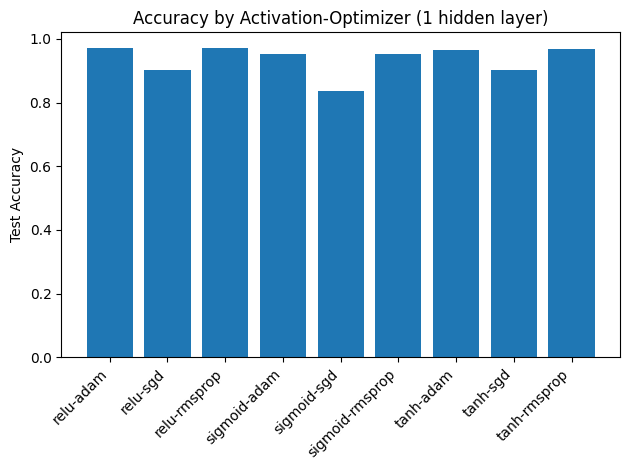

In [11]:
# Accuracy bar
plt.figure()
plt.bar(range(len(labels)), accs)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel("Test Accuracy")
plt.title("Accuracy by Activation-Optimizer (1 hidden layer)")
plt.tight_layout()
plt.show()

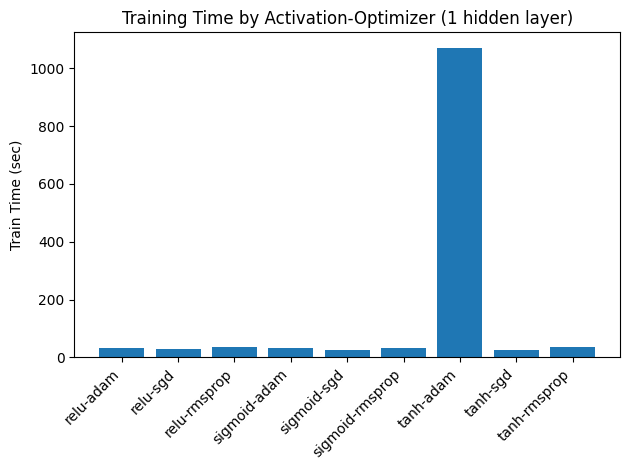

In [12]:
# Time bar
plt.figure()
plt.bar(range(len(labels)), times)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel("Train Time (sec)")
plt.title("Training Time by Activation-Optimizer (1 hidden layer)")
plt.tight_layout()
plt.show()

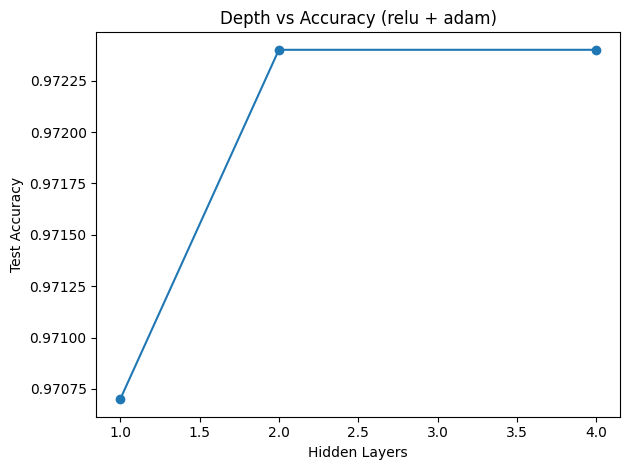

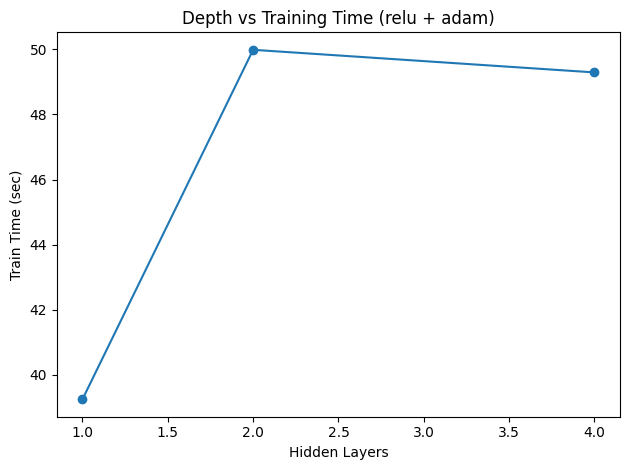

In [13]:
# B) Depth vs accuracy/time
plt.figure()
plt.plot(df_depth["layers"], df_depth["test_accuracy"], marker="o")
plt.xlabel("Hidden Layers")
plt.ylabel("Test Accuracy")
plt.title("Depth vs Accuracy (relu + adam)")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df_depth["layers"], df_depth["train_time_sec"], marker="o")
plt.xlabel("Hidden Layers")
plt.ylabel("Train Time (sec)")
plt.title("Depth vs Training Time (relu + adam)")
plt.tight_layout()
plt.show()



## 9) What to expect (and how to interpret)

- **Sigmoid vs ReLU in hidden layers**  
  - `sigmoid` saturates for large |x|, gradients shrink → typically slower training and lower accuracy in deeper nets.  
  - `relu` avoids saturation for x>0, speeds convergence and usually yields higher accuracy.

- **Softmax at the output**  
  - For multi-class classification, `softmax + categorical_crossentropy` is standard and interpretable (probabilities sum to 1).  
  - You can also use a **linear** output with `CategoricalCrossentropy(from_logits=True)`; numerically similar if implemented correctly.  
  - Using a 10-way **sigmoid** with binary cross-entropy treats the task as multi-label and usually underperforms/produces less calibrated probabilities.

- **Depth**  
  - Doubling hidden layers increases representational power but also training time and risk of overfitting.  
  - For MNIST with MLPs, 1–2 layers often suffice; going much deeper helps less than using CNNs.

- **Optimizers**  
  - `adam` typically converges fastest and reaches strong accuracy in a few epochs.  
  - `sgd` may require more epochs and careful learning rate tuning.  
  - `rmsprop` is often between `adam` and `sgd` in speed/stability.




# 10) Easy knobs to tweak 

In [14]:
EPOCHS = 8          # try 5 → 8 → 12
BATCH  = 128        # try 64 or 256
HIDDEN_UNITS = 256  # try 64, 128, 256
L2 = 0.0            # e.g., 1e-4 with kernel_regularizer=tf.keras.regularizers.l2(L2)
DROPOUT = 0.1       # try 0.0 to 0.3

# Example: quick rerun with different units and dropout
model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(HIDDEN_UNITS, activation="relu"),
    Dropout(DROPOUT),
    Dense(10, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test_oh, verbose=0)
print({"test_acc": test_acc, "test_loss": test_loss})


C:\Users\DuaaHilal\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


{'test_acc': 0.979200005531311, 'test_loss': 0.07046988606452942}


# 11) Save result tables to CSV 

In [ ]:
import pandas as pd
pd.DataFrame([{k: v for k, v in r.items() if k != "history"} for r in results]).to_csv("mnist_activation_optimizer_results.csv", index=False)
pd.DataFrame([{k: v for k, v in r.items() if k != "history"} for r in depth_results]).to_csv("mnist_depth_results.csv", index=False)
print("Saved: mnist_activation_optimizer_results.csv, mnist_depth_results.csv")
